# Anomaly Detection by Analyzing NBA Players
_The aim of this project is to cluster NBA players based on their age and performance improvement in key efficiency statistics, comparing Playoff data versus Regular Season data. This is a highly sought-after value for current contender teams, and its identification and market anticipation capabilities are strong assets in the league planning.
Once this is achieved, we will seek to identify anomalies within each cluster to gain a better understanding of these groupings._ 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
import warnings

warnings.filterwarnings("ignore")

To achieve our goal, we will rely on the Kaggle dataset [2022-2023 NBA Player Stats](https://www.kaggle.com/datasets/vivovinco/20222023-nba-player-stats-regular), which includes player averages for the Regular Season and Playoffs of the 2022/2023 season, obtained from the [Basketball Reference](https://www.basketball-reference.com/leagues/NBA_2023_per_game.html) website.

In [2]:
df_RS = pd.read_csv('2022-2023 NBA Player Stats - Regular.csv', delimiter=";", encoding="latin-1")
df_PO = pd.read_csv('2022-2023 NBA Player Stats - Playoffs.csv', delimiter=";", encoding="latin-1")

- What we will do is select the players who have participated in both Playoffs and Regular Season and subtract their averages to assess whether improvements have been made or not.

In [3]:
df_RS_ = pd.merge(df_PO, df_RS , on=['Player', 'Tm'], how='inner').filter(regex='^(?!.*_x$)')
df_PO_ = pd.merge(df_PO, df_RS_ , on=['Player', 'Tm'], how='inner').filter(regex='^(?!.*_y$)')

In [4]:
RS_columns = {col: col.split('_')[0] for col in df_RS_.columns}
PO_columns = {col: col.split('_')[0] for col in df_PO_.columns}
df_RS_.rename(columns=RS_columns, inplace=True)
df_PO_.rename(columns=PO_columns, inplace=True)

In [5]:
set(df_PO_.columns) == set(df_RS_.columns)

True

In [6]:
cols = df_PO_.columns.values

df_dif = df_PO_.copy()
df_dif[cols[7:]] = df_dif[cols[7:]] - df_RS_[cols[7:]]

- To standardize these data and have them all on the same scale, we will scale them between -1 and 1. This allows us to preserve the sign as a value to observe whether there is an improvement or not in performance.

In [7]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df_dif[list(cols[7:])+['Age']] = scaler.fit_transform(df_dif[list(cols[7:])+['Age']])

- To carry out our task, we decided to use the K-means clustering technique. We will then assess the most suitable number of clusters to group players based on their age and minutes played.

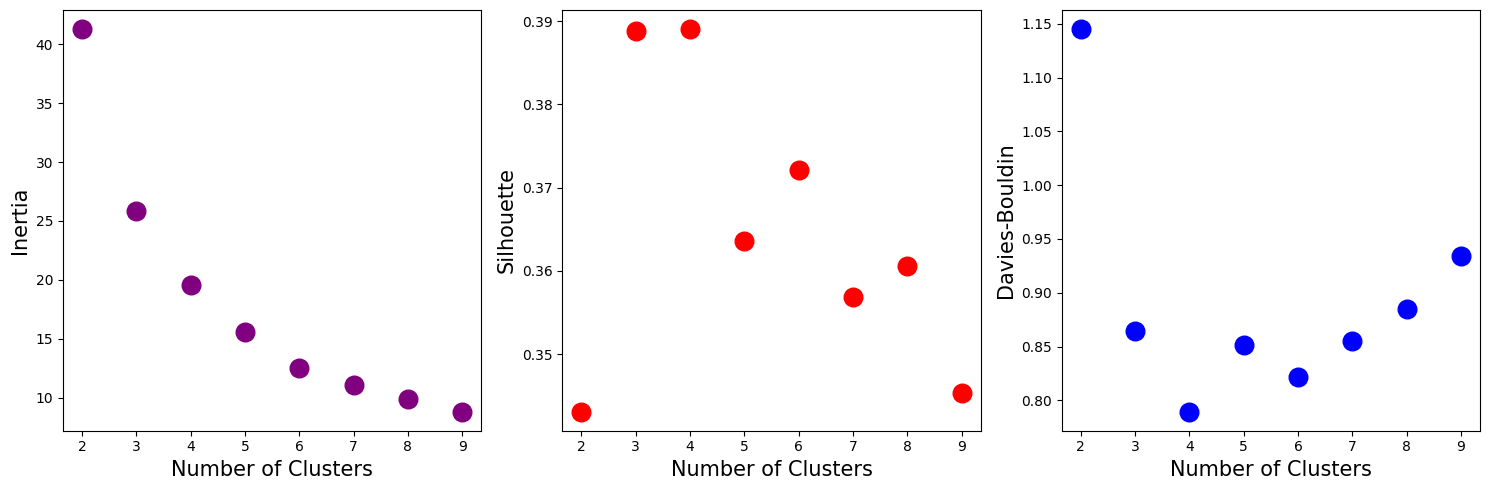

In [8]:
a = 'MP'
b = 'Age'

X = df_dif[[a, b]].values

inercias = []
siluetas = []
davies_bouldins = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    silueta = silhouette_score(X, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(X, kmeans.labels_)
    inercias.append(kmeans.inertia_)
    siluetas.append(silueta)
    davies_bouldins.append(davies_bouldin)

    
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(range(2, 10), inercias, marker="o", s=180, color="purple")
axs[0].set_xlabel("Number of Clusters", fontsize=15)
axs[0].set_ylabel("Inertia", fontsize=15)

axs[1].scatter(range(2, 10), siluetas, marker="o", s=180, color="red")
axs[1].set_xlabel("Number of Clusters", fontsize=15)
axs[1].set_ylabel("Silhouette", fontsize=15)

axs[2].scatter(range(2, 10), davies_bouldins, marker="o", s=180, color="blue")
axs[2].set_xlabel("Number of Clusters", fontsize=15)
axs[2].set_ylabel("Davies-Bouldin", fontsize=15)

plt.tight_layout()
plt.show()

- Based on these results, we can see that the correct choice is **n_clusters=4**, as the silhouette metric indicates better clustering when the value is closer to 0, and the Davies-Bouldin metric, the closer it is to 0.

In [9]:
kmeans = KMeans(n_clusters=4, random_state=42).fit(X)

In [10]:
x_mean = df_RS['Age'].mean()
min_value = df_RS['Age'].min()
max_value = df_RS['Age'].max()
max_range = 1.0
min_range = -1.0

x_mean_norm = (x_mean - min_value) / (max_value - min_value) * (max_range - min_range) + min_range
print(x_mean_norm)

-0.3891272331433694


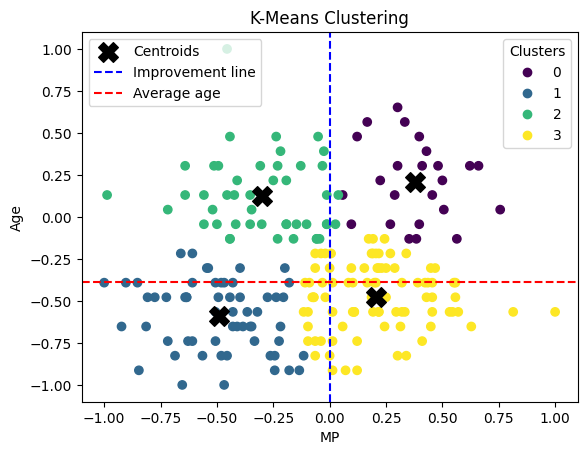

In [22]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

fig, ax = plt.subplots()

scatter1 = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
legend1 = ax.legend(*scatter1.legend_elements(), title="Clusters", loc='upper right')
ax.add_artist(legend1)
scatter2 = plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=200, label="Centroids")

plt.axvline(x=0, color='blue', linestyle='--', label="Improvement line")
plt.axhline(y=x_mean_norm, color='red', linestyle='--', label="Average age")

ax.legend(loc="upper left")

plt.xlabel(a)
plt.ylabel(b)
plt.title('K-Means Clustering')
plt.show()

- Based on the results, we can observe common characteristics in each cluster that allow us to identify them semantically:
    - Cluster 0: Veteran players who increased their minutes played in the Playoffs.
    - Cluster 1: Young players who reduced their minutes played in the Playoffs.
    - Cluster 2: Veteran players who reduced their minutes played in the Playoffs.
    - Cluster 3: Young or players in their prime who increased their minutes played in the Playoffs.

- Based on the results, none of the clusters holds more value than the others. These groups can hold different value for different teams, depending on their current sporting situation and the market value assigned to these players at a given time. However, considering global conditions, we can conclude that **Cluster 3** is the most coveted, potentially leading to higher competition.

- Now we will use 2 methods for anomaly detection. The first one involves calculating the Euclidean distance between all points in each cluster and their centroid, and setting a threshold beyond which a point is considered an anomaly. The second method involves applying the Local Outlier Factor algorithm.

In [12]:
distances = pairwise_distances(X, centroids, metric='euclidean')
distances_to_centroids = np.min(distances, axis=1)

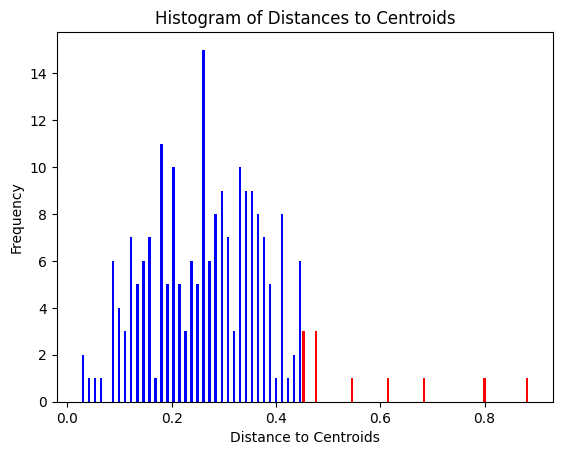

In [13]:
threshold = 0.45
distances_above_threshold = distances_to_centroids[distances_to_centroids > threshold]
distances_below_threshold = distances_to_centroids[distances_to_centroids <= threshold]

plt.hist(
    [distances_above_threshold, distances_below_threshold],
    bins = 75,
    color=['red', 'blue'])
plt.xlabel('Distance to Centroids')
plt.ylabel('Frequency')
plt.title('Histogram of Distances to Centroids')
plt.show()

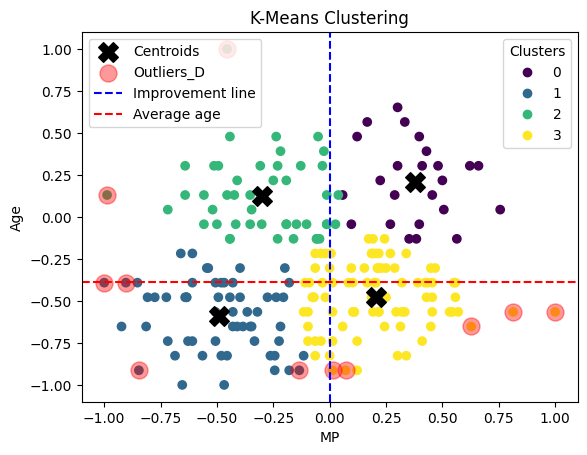

In [14]:
fig, ax = plt.subplots()

scatter1 = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
legend1 = ax.legend(*scatter1.legend_elements(), title="Clusters", loc='upper right')
ax.add_artist(legend1)
scatter2 = plt.scatter(centroids[:, 0], centroids[:, 1], c='k', marker='X', s=200, label="Centroids")

X_outlier_D = df_dif.iloc[np.where(distances_to_centroids > threshold)[0]][[a, b]].values

scatter3 = plt.scatter(X_outlier_D[:, 0], X_outlier_D[:, 1], c='red', marker='o', s=150, alpha=0.4, label="Outliers_D")

plt.axvline(x=0, color='blue', linestyle='--', label="Improvement line")
plt.axhline(y=x_mean_norm, color='red', linestyle='--', label="Average age")

ax.legend(loc="upper left")

plt.xlabel(a)
plt.ylabel(b)
plt.title('K-Means Clustering')
plt.show()

In [15]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
outlier_scores = -lof.fit_predict(X)

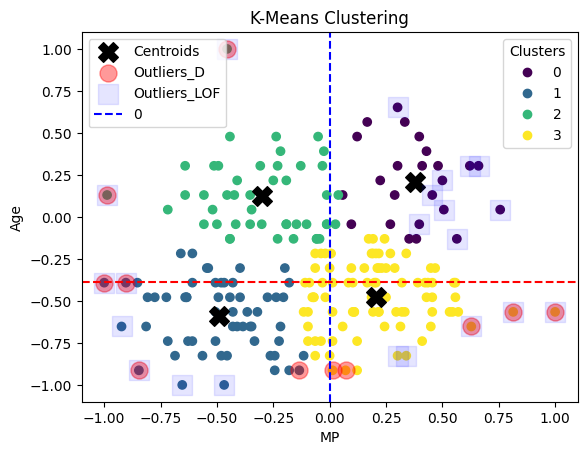

In [16]:
fig, ax = plt.subplots()

scatter1 = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
legend1 = ax.legend(*scatter1.legend_elements(), title="Clusters", loc='upper right')
ax.add_artist(legend1)
scatter2 = plt.scatter(centroids[:, 0], centroids[:, 1], c='k', marker='X', s=200, label="Centroids")

X_outlier_LOF = df_dif.iloc[np.where(outlier_scores == 1)[0]][[a, b]].values

scatter3 = plt.scatter(X_outlier_D[:, 0], X_outlier_D[:, 1], c='red', marker='o', s=150, alpha=0.4, label="Outliers_D")
scatter4 = plt.scatter(X_outlier_LOF[:, 0], X_outlier_LOF[:, 1], c='blue', marker='s', s=200, alpha=0.1, label="Outliers_LOF")

plt.axvline(x=0, color='blue', linestyle='--', label="0")
plt.axhline(y=x_mean_norm, color='red', linestyle='--', label="")

ax.legend(loc="upper left")

plt.xlabel(a)
plt.ylabel(b)
plt.title('K-Means Clustering')
plt.show()

- After observing the plotted results of anomalies, we proceed to visualize which players are identified as anomalies, which ones are identified by both methods, and which ones are unique to each method.

In [17]:
df_check = pd.DataFrame({'Player': df_dif['Player'], 'Tm': df_dif['Tm'], 'labels': labels, a: df_dif[a], b: df_dif[b]})

In [18]:
df_check.iloc[np.where(distances_to_centroids > threshold)[0]]

,Player,Tm,labels,MP,Age
2,Nickeil Alexander-Walker,MIN,3,1.000000,-0.565217
9,Patrick Baldwin Jr.,GSW,1,-0.134615,-0.913043
15,Malik Beasley,LAL,1,-0.903846,-0.391304
80,Udonis Haslem,MIA,2,-0.455128,1.000000
92,Jaren Jackson Jr.,MEM,3,0.628205,-0.652174
93,Reggie Jackson,DEN,2,-0.987179,0.130435
106,Jonathan Kuminga,GSW,1,-0.846154,-0.913043
132,Shake Milton,PHI,1,-1.000000,-0.391304
133,Josh Minott,MIN,3,0.070513,-0.913043
185,Jaden Springer,PHI,3,0.012821,-0.913043


In [19]:
df_check.iloc[np.where(outlier_scores == 1)[0]]

,Player,Tm,labels,MP,Age
2,Nickeil Alexander-Walker,MIN,3,1.000000,-0.565217
15,Malik Beasley,LAL,1,-0.903846,-0.391304
31,Jimmy Butler,MIA,0,0.500000,0.217391
37,Max Christie,LAL,1,-0.467949,-1.000000
56,Kevin Durant,PHO,0,0.660256,0.304348
57,Anthony Edwards,MIN,3,0.339744,-0.826087
64,Rudy Gobert,MIN,0,0.397436,-0.043478
80,Udonis Haslem,MIA,2,-0.455128,1.000000
82,Tyler Herro,MIA,1,-0.923077,-0.652174
85,Jrue Holiday,MIL,0,0.455128,0.130435


In [20]:
df_PO_.iloc[list(set(np.where(outlier_scores == 1)[0]) & set(np.where(distances_to_centroids > threshold)[0]))]

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
192,196,Xavier Tillman Sr.,C,24,MEM,6,6,30.5,4.0,7.5,...,0.600,2.8,5.2,8.0,3.2,0.7,0.7,0.7,2.8,8.7
2,3,Nickeil Alexander-Walker,SG,24,MIN,5,4,29.6,3.0,7.0,...,0.667,0.2,1.8,2.0,1.4,0.6,0.2,0.8,1.8,8.4
132,135,Shake Milton,SG,26,PHI,6,0,3.5,0.5,0.8,...,1.000,0.0,0.5,0.5,0.3,0.3,0.0,0.2,0.5,1.3
106,109,Jonathan Kuminga,PF,20,GSW,10,0,6.1,1.3,2.4,...,0.556,0.4,0.5,0.9,0.5,0.2,0.0,0.4,0.5,3.4
15,16,Malik Beasley,SG,26,LAL,11,0,8.3,0.9,3.1,...,1.000,0.3,0.5,0.7,0.2,0.1,0.0,0.2,0.5,3.0
80,82,Udonis Haslem,C,42,MIA,2,0,1.5,0.0,1.5,...,0.000,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0
92,94,Jaren Jackson Jr.,C,23,MEM,6,6,36.7,5.8,13.8,...,0.861,3.3,4.5,7.8,1.5,1.0,2.0,3.0,4.0,18.0
93,95,Reggie Jackson,PG,32,DEN,6,0,3.0,0.2,0.3,...,0.000,0.0,0.3,0.3,0.3,0.2,0.0,0.2,0.0,0.5


In [21]:
df_PO_.iloc[list(set(np.where(outlier_scores == 1)[0]) ^ set(np.where(distances_to_centroids > threshold)[0]))]

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
130,133,Khris Middleton,SF,31,MIL,5,5,34.6,8.0,17.2,...,0.867,1.4,5.0,6.4,6.2,0.6,0.0,3.4,3.0,23.8
133,136,Josh Minott,SF,20,MIN,1,0,6.0,0.0,1.0,...,0.000,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0
136,139,Evan Mobley,PF,21,CLE,5,5,37.6,4.4,9.6,...,0.625,3.0,7.0,10.0,2.0,0.6,1.2,2.4,2.6,9.8
9,10,Patrick Baldwin Jr.,SF,20,GSW,3,0,3.7,0.0,1.0,...,0.000,0.0,1.0,1.0,0.3,0.0,0.0,0.0,0.0,0.0
31,32,Jimmy Butler,PF,33,MIA,22,22,39.7,9.4,20.1,...,0.806,2.1,4.3,6.5,5.9,1.8,0.6,1.9,1.7,26.9
163,166,Norman Powell,SG,29,LAC,5,3,33.4,7.2,15.2,...,0.774,0.8,2.2,3.0,2.2,0.8,0.4,1.6,3.2,21.8
37,38,Max Christie,SG,19,LAL,9,0,3.7,0.6,1.1,...,0.500,0.1,0.7,0.8,0.3,0.0,0.1,0.0,0.0,1.4
56,57,Kevin Durant,PF,34,PHO,11,11,42.4,9.7,20.4,...,0.917,0.6,8.1,8.7,5.5,0.8,1.4,3.5,2.6,29.0
57,58,Anthony Edwards,SG,21,MIN,5,5,39.8,11.0,22.8,...,0.846,0.6,4.4,5.0,5.2,1.8,2.0,1.6,2.6,31.6
185,188,Jaden Springer,SG,20,PHI,4,0,4.3,1.0,1.0,...,0.500,0.0,0.0,0.0,0.0,0.3,0.0,0.3,0.5,2.3


- As interesting results from our analysis, we can deduce the following:
    - Cluster 0:
        - As a general rule, anomalies in this cluster are attributed to players who usually have more playing time during the Regular Season but had reduced participation due to injuries or players who often practice tactics like "low management" to be in better shape for the offseason.
        - Notably, there's the presence of players like **Russell Westbrook**, whose playing time increased due to the injury of his teammate **Paul George** and his strong performance during the 5 games played.
    - Cluster 1:
        - In this case, we are talking about situations similar to the previous cluster, where the player suffered an injury during the Playoffs _(Tyler Herro)_ or players who are very young and lack experience or struggle with the transition from Regular Season to Playoffs.
        - Notable names include **Malik Beasley**, as he tends to attract attention from contender teams in the free agency for playing in these types of moments.
    - Cluster 2:
        - In this case, we have two quite special cases. One is **Udonis Haslem**, who has not contributed much to his team in terms of performance for years and whose role is mainly associated with leadership within the locker room. The other case is **Reggie Jackson**, who despite having good Playoff runs with his previous team _L.A. Clippers_ in recent years and winning the championship this season with _Denver Nuggets_, had minimal participation in the Playoffs, playing only 6 games with an average of 3.5 minutes per game.
    - Cluster 3:
        - Anomalies in this cluster belong to two types of players. The first type includes players whose presence in both Playoffs and Regular Season has been marginal, causing their stats to be magnified due to a very small sample size. The second type includes early star players in the league who, at a very young age, have significant influence on their team, such as **Evan Mobley** or **Anthony Edwards**.